# Cluster Poses for batsman recognition

## Description:

Taking the highlight videos, the stroke labels, and the person poses for first frames, cluster the poses to identify the batsman.

In [8]:
from __future__ import print_function

import os
import seaborn as sns
import cv2
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

#from utils import crop_centre
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
#sns.set()

%matplotlib inline

# Server Paths
DATASET = "/opt/datasets/cricket/ICC_WT20"
POSE_FEATS = "/home/arpan/cricket/output_json"
LABELS = "/home/arpan/VisionWorkspace/shot_detection/supporting_files/sample_set_labels/sample_labels_shots/ICC WT20"

# Local Paths
if not os.path.exists(DATASET):
    DATASET = "/home/arpan/VisionWorkspace/VideoData/sample_cricket/ICC WT20"
    POSE_FEATS = "/home/arpan/VisionWorkspace/Cricket/batsman_pose_track/output_json"
    LABELS = "/home/arpan/VisionWorkspace/Cricket/scripts/supporting_files/sample_set_labels/sample_labels_shots/ICC WT20"    

poses_numpy_feats = 'dump/poses_numpy'

## 1. Extract poses of the persons and write to disk

In [2]:
def getPoseVectors(poseFilePrefix, f_no):
    """
    Receives the pose file info and returns the person keypoints for the frame as a matrix.
    """
    poseFile = poseFilePrefix+"_{:012}".format(f_no)+"_keypoints.json"
    poseFile = os.path.join(POSE_FEATS, poseFile)
    with open(poseFile, 'r') as fp:
        pose_kp = json.load(fp)
    # form a list of 2D matrices.
    
    people = pose_kp['people']
    people_list = []
    for i, p in enumerate(people):
        person_pose_vals = p['pose_keypoints_2d']   # get list of values (x1, y1 ,c1, x2, y2, c2 ...)
        person_pose = []
        for j in range(0, len(person_pose_vals), 3):
            x = (person_pose_vals[j]/640)
            y = (person_pose_vals[j+1]/360)
            c = person_pose_vals[j+2]
            #print(x,y,c)
            #img[(y-2):(y+2),(x-2):(x+2),:] = 255  # do white
            person_pose.extend([x, y])
        
        #print("Poses for person {} : {} ".format(i, person_pose))
        people_list.append(person_pose)
        #break  # remove to display for all the persons in the image
        
    return np.array(people_list)      # return 2D matrix persons 
    

        
# From flow.py
def extract_poses(vidFile, frame_indx, maxFrames):
    '''
    Extract poses features of persons in first maxFrames of the cricket strokes in the vidFile. The strokes
    are a list of tuples in the frame_indx
    Parameters:
    ------
    vidFile: str
        video file name (.avi)
    frame_indx: list of tuples (start_frameNo, end_frameNo)
        each tuple in the list denotes a stroke.
    maxFrames: consider first maxFrames of a particular stroke
    '''
#    if not os.path.exists(f_loc):
#        os.makedirs(f_loc)
    poseFilePrefix = vidFile.rsplit(".", 1)[0]
    cap = cv2.VideoCapture(os.path.join(DATASET, vidFile))
    if not cap.isOpened():
        print("Capture object not opened. Aborting !!")
        sys.exit(0)
    nFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()
    
    stroke_features = []
    vn = []
    fno = []
    
    for m, n in frame_indx:
        if maxFrames<1 or n-m+1<maxFrames:
            print("stroke {} :: skipped".format((m, n)))
            continue
        else:
            print("stroke {} ".format((m, n)))
        
        frameNo = m
        while (frameNo-m+1) <= maxFrames:
            poses_mat = getPoseVectors(poseFilePrefix, frameNo)
            npersons = poses_mat.shape[0]
            stroke_features.append(poses_mat)
            vn.extend([vidFile for i in range(npersons)])
            fno.extend([frameNo for i in range(npersons)])
            frameNo+=1
            
        #break
        
    stroke_features = np.vstack(stroke_features)
    # write the stroke features as npy file
    #np.save(os.path.join(f_loc, "angMap_"+str(m)+"_"+str(n)+".npy"), stroke_features)
    #np.save(os.path.join(f_loc, "angMap.npy"), stroke_features)
    return stroke_features, vn, fno


def extract_all_feats(vidsPath, labelsPath, maxFrames):
    video_files = os.listdir(vidsPath)
    json_files = os.listdir(labelsPath)
    vnames = []
    f_nos = []
    all_feats = None
    for i, v_file in enumerate(video_files):
        print('-'*60)
        print(str(i+1)+". v_file :: ", v_file)
        video_name = v_file.split('.')[0]
        #print("video_name :: ", video_name)
        json_file = video_name + '.json'
        #print("json file :: ", json_file)
        if json_file not in json_files:
            print("json file not found!")
            sys.exit(0)
        with open(os.path.join(LABELS, json_file), 'r') as fr:
            frame_dict = json.load(fr)

        frame_indx = list(frame_dict.values())[0]
        #print('frame_indx :: ', frame_indx)

        #f_loc = os.path.join(flow_numpy_path, video_name)
        stroke_features, vnm, fno = extract_poses(v_file, frame_indx, maxFrames)
        if all_feats is None:
            all_feats = stroke_features
        else:
            all_feats = np.vstack((all_feats, stroke_features))
        vnames.extend(vnm)
        f_nos.extend(fno)
        #break
    return vnames, f_nos, all_feats




In [3]:

def apply_PCA(flows):
    pca = PCA(n_components=2)
    pca.fit(flows)
    flows_pca = pca.transform(flows)
    return flows_pca

def apply_tsne(flows):
    return TSNE(n_components=2).fit_transform(flows)

def kmeans(flows, clusters=4):
    km = KMeans(n_clusters=clusters, algorithm='elkan', random_state=0)
    km.fit(flows)
    return km

def dbscan(flows, clusters=4, epsilon=100):
    db = DBSCAN(eps=epsilon, min_samples=10).fit(flows)
    return db


In [4]:
def plot_clusters(data, labels):
    n_clusters = max(labels) + 1
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    markers = list("12348spphH+xXdD")
    for n_cluster in range(n_clusters):
        # print("n_cluster", n_cluster)
        # print("marker", markers[n_cluster])
        cls_data = data[labels==n_cluster]
        plt.scatter(cls_data[:,0], cls_data[:,1], c=colors[n_cluster%8],marker = markers[n_cluster], label=str(n_cluster))
    plt.legend(loc='upper right')
    plt.savefig(poses_numpy_feats+str(n_cluster)+'_cluster.png')
    plt.show()

def plot_density_clusters(data, labels):
    min_cluster = min(labels)
    max_cluster = max(labels)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    markers = list("12348spphH+xXdD12348spphH+xXdD12348spphH+xXdD12348spphH+xXdD")
    for n_cluster in range(min_cluster, max_cluster+1, 1):
        # print("n_cluster", n_cluster)
        # print("marker", markers[n_cluster])
        cls_data = data[labels==n_cluster]
        plt.scatter(cls_data[:,0], cls_data[:,1], c=colors[(n_cluster-min_cluster)%8],marker = markers[n_cluster-min_cluster], label=str(n_cluster))
    plt.legend(loc='upper right')
    plt.savefig(poses_numpy_feats+str(n_cluster)+'_cluster.png')
    plt.show()    
    
def plot_sse_score(sse_list):
    plt.plot(sse_list, label='sse score', c='r')
    plt.title('sse score vs cluster size')
    plt.savefig('sse_plot.png')
    plt.show()
    

def evaluate(labels):
    global f
    flows_path = os.listdir(flow_numpy_path)
    n_clusters = max(labels) + 1
    print("clusters, ", n_clusters)
    for i in range(n_clusters):
        ######
        try:
            os.makedirs(os.path.join(flow_numpy_path, str(i)))
        except Exception as e:
            print("except", e)
        #######
        # print("list(np.where(labels==i)", np.where(labels==i)[0])
        for j in np.where(labels==i)[0]:
            # print(j, "flows_path", flows_path[j])
            # print("flows_path[j].split('.')", flows_path[j].split('.'))
            vid_data = flows_path[j].split('.')[0].split('_')
            # print("vid_data", vid_data)
            m, n = map(int, vid_data[-2:])
            vid_name = vid_data[0]
            f = ''.join(vid_name.split(' ')[2:-1])
            save_video(join(vid_data_path, vid_name+'.avi'), m, n, i)


In [5]:
def plotPoseKeyPoints(img, pose_kp):
    '''
    img: input image RGB
    pose_kp: person vector of size 1 x 50 
    '''
    person_pose_vals = pose_kp.ravel().tolist()   # get list of values (x1, y1, x2, y2, ...)
        
    for j in range(0, len(person_pose_vals), 2):
        x = int(person_pose_vals[j]*640)
        y = int(person_pose_vals[j+1]*360)
        
        #print(x,y,c)
        img[(y-2):(y+2),(x-2):(x+2),:] = 255  # do white
        
    #break  # remove to display for all the persons in the image
    return img

def getVideoFrame(vidFile, frameNo):
    cap = cv2.VideoCapture(os.path.join(DATASET, vidFile))
    if not cap.isOpened():
        print("Capture object not opened. Aborting !!")
        sys.exit(0)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frameNo)
    ret, img = cap.read()
    cap.release()
    if not ret:
        print("Frame not read !!")
        return None
    else:
        return img


def visualize_of(mag, ang):
    c = 3
    h, w = mag.shape
    hsv = np.zeros((h, w, c), dtype=np.uint8)
    hsv[...,1] = 255
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    plt.figure()
    plt.imshow(bgr)
    #plt.show()

In [6]:
def visualizeClusterFrames(all_feats, vnames, fno, labels, cluster_no=0):
    """
    all_feats: np.array
        npersons x 50 matrix for person poses
    vnames: list
        for each row of all feats, a corresponding videoname
    fno: list
        for each row of all feats, a corresponding frame no in video file given in vname
    labels: np.array
        1D array of cluster labels
    cluster_no: int
        which cluster no. to visualize
    """
    # get the cluster labels corresponding to 
    labels_indx = np.where(labels==cluster_no)[0]   # an np.array of 1D with index values
    for idx, i in enumerate(labels_indx.ravel().tolist()):
        img = getVideoFrame(vnames[i], fno[i])
        img = plotPoseKeyPoints(img, all_feats[i, :])
        plt.figure()
        plt.imshow(img)
        if idx==1:
            cv2.imwrite("pose_frame.png", img)
        if idx == 100:
            break
    


all_feats shape ::  (2498, 50)
Clustering... :: nclusters = 2
Clustering... :: nclusters = 3
Clustering... :: nclusters = 4
Clustering... :: nclusters = 5
Clustering... :: nclusters = 6
Clustering... :: nclusters = 7
Clustering... :: nclusters = 8
Clustering... :: nclusters = 9


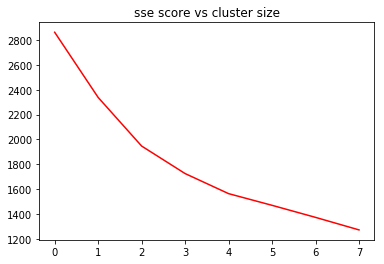

final clustering



In [9]:
if __name__ == '__main__':
    maxFrames = 1
    
    #vnames, f_nos, all_feats = extract_all_feats(DATASET, LABELS, maxFrames)
    #np.save(os.path.join(poses_numpy_feats, "poses_feats_"+str(maxFrames)+".npy"), all_feats)
    all_feats = np.load(os.path.join(poses_numpy_feats, "poses_feats_"+str(maxFrames)+".npy"))
    
    print("all_feats shape :: ", all_feats.shape)
    
    #all_feats[np.isinf(all_feats)] = 0
    
    #flows, flows_path  = get_flows(flows_numpy_path)
    #print("flows", np.shape(flows))
    sse_list = []
    
    for i in range(2, 10):
        print("Clustering... :: nclusters = "+str(i))
        km = kmeans(all_feats, i)
        labels = km.labels_
        sse_list.append(km.inertia_)
        #print("labels_", labels)
    res_cluster_size = np.argmin(sse_list)
    plot_sse_score(sse_list)
    print("final clustering\n")
    km = kmeans(all_feats, 5)
    labels = km.labels_
    #evaluate(labels)
    
    
    


In [13]:
all_feats

array([[0.56932031, 0.22958694, 0.5679    , ..., 0.31111667, 0.55711563,
        0.30843889],
       [0.71612031, 0.48505278, 0.74206563, ..., 0.74582778, 0.77110937,
        0.74322222],
       [0.        , 0.        , 0.52810625, ..., 0.        , 0.54337031,
        0.91976389],
       ...,
       [0.        , 0.        , 0.49453906, ..., 0.        , 0.5082125 ,
        0.73773889],
       [0.49295   , 0.22947806, 0.49458437, ..., 0.349175  , 0.50362656,
        0.35456944],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

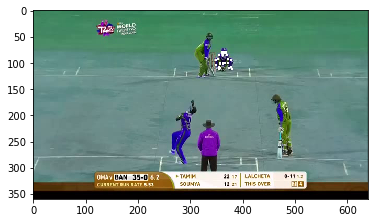

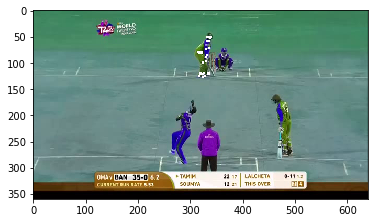

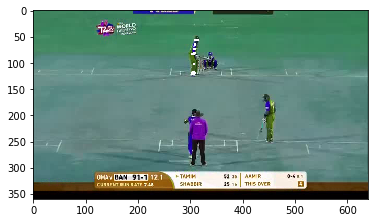

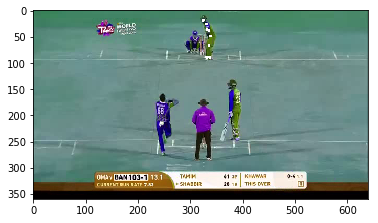

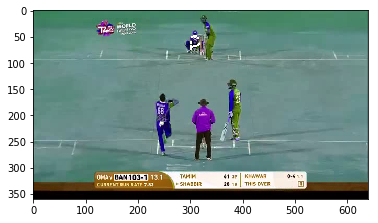

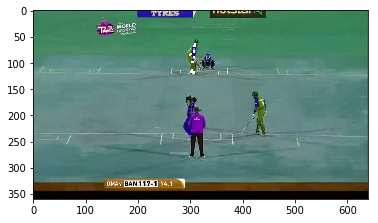

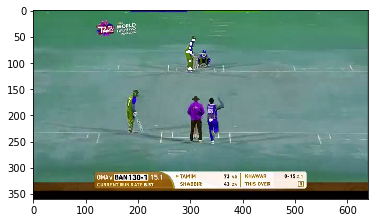

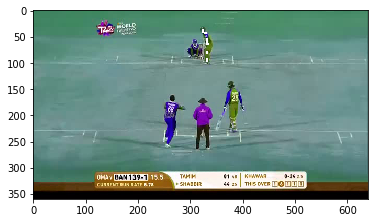

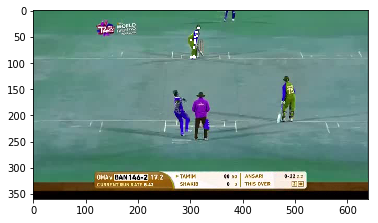

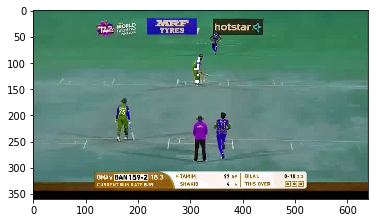

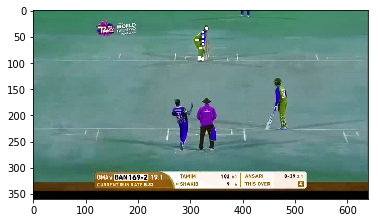

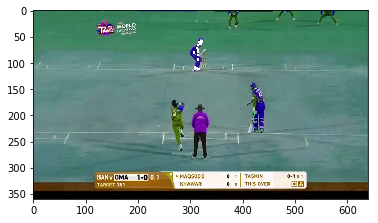

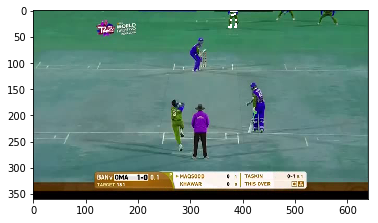

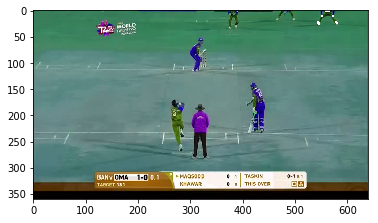

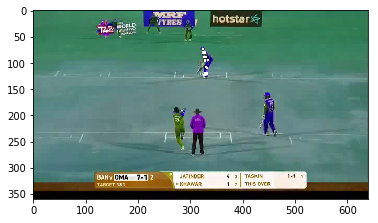

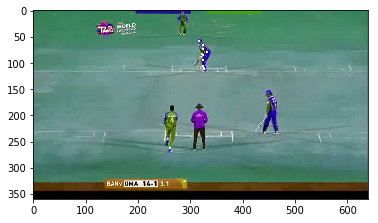

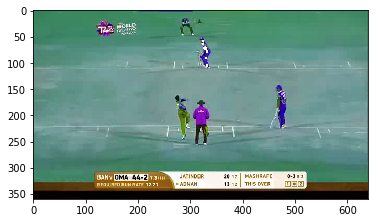

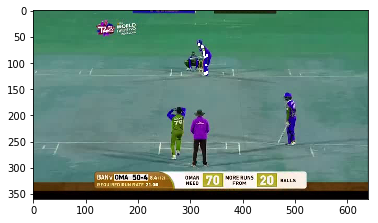

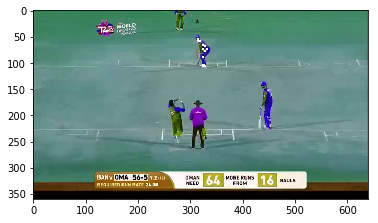

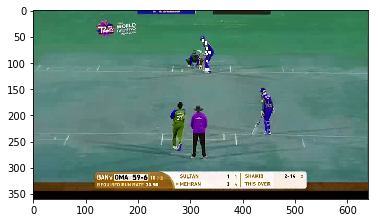

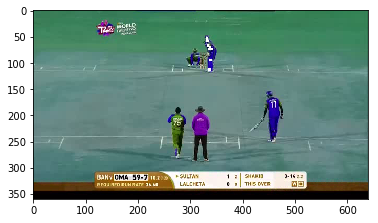

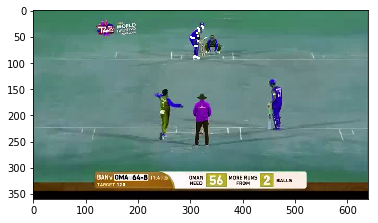

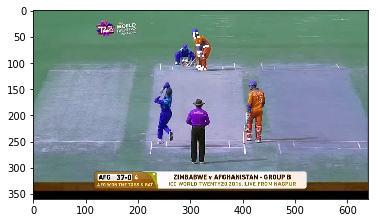

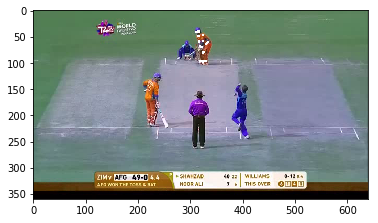

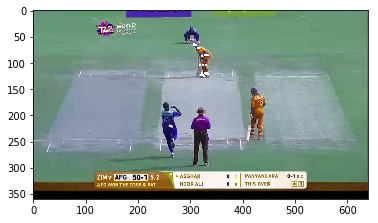

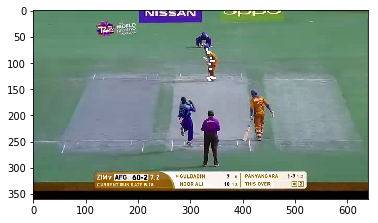

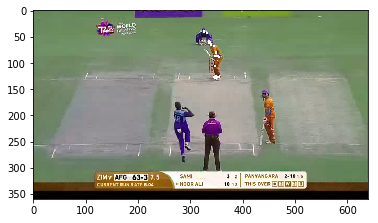

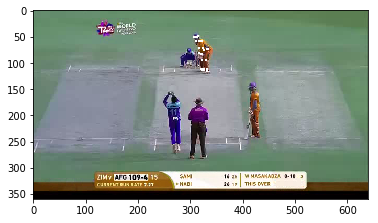

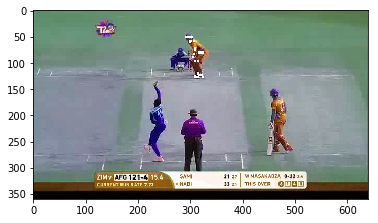

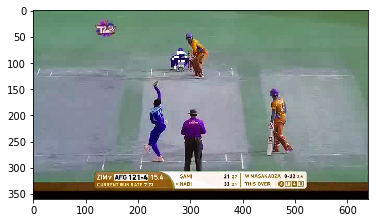

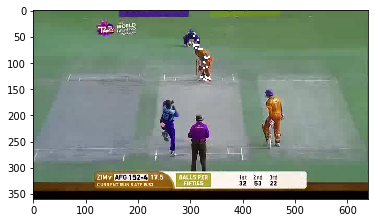

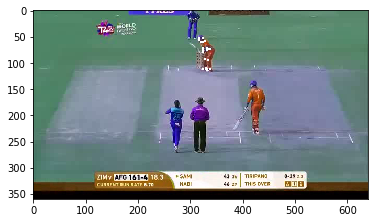

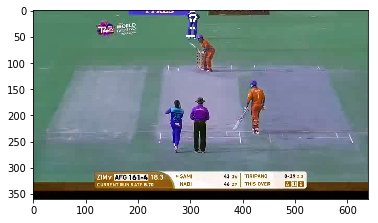

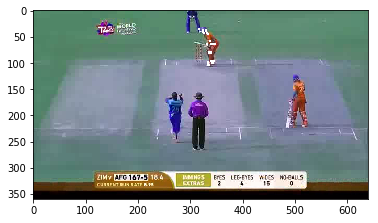

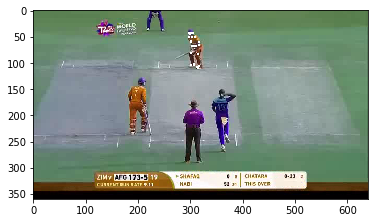

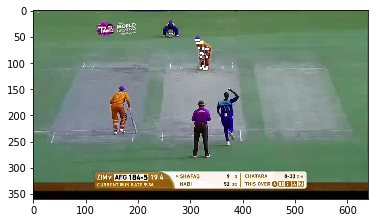

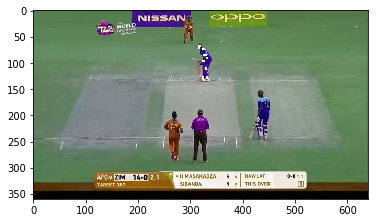

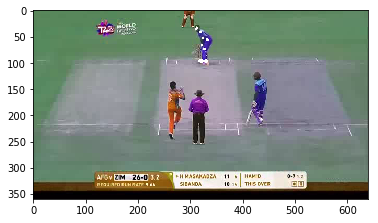

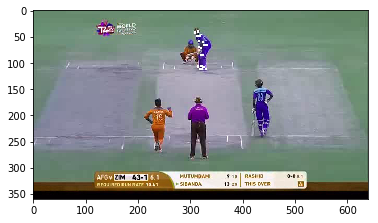

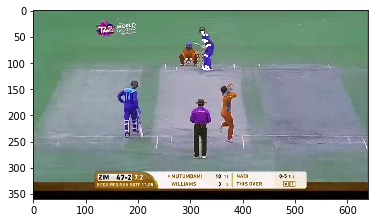

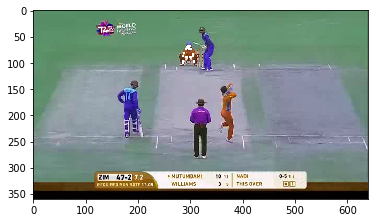

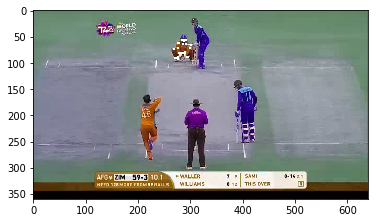

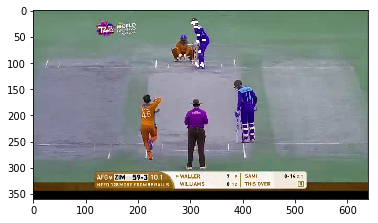

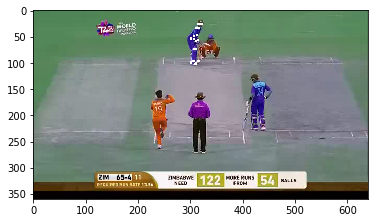

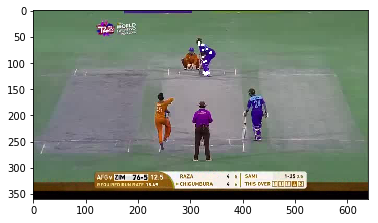

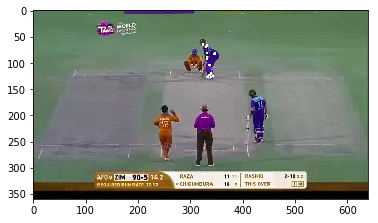

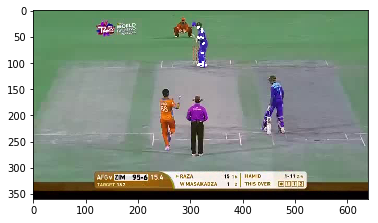

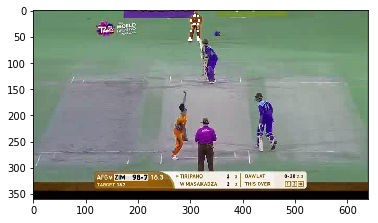

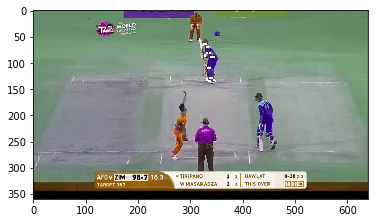

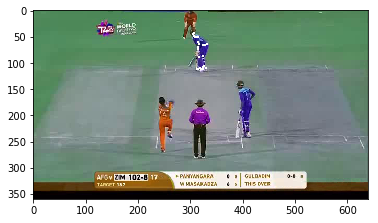

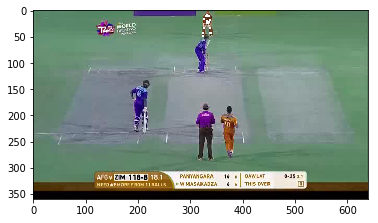

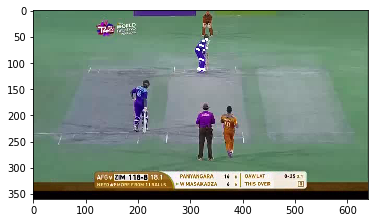

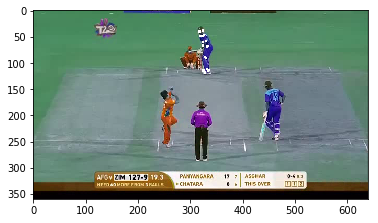

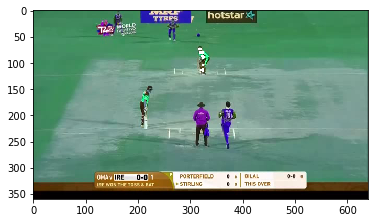

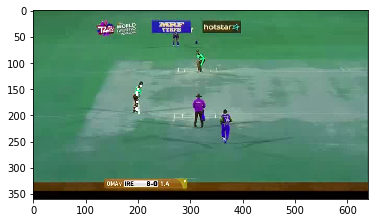

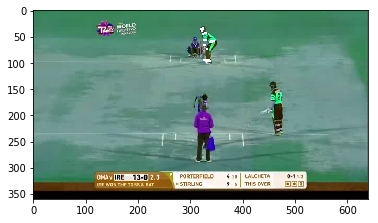

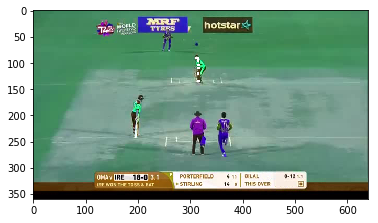

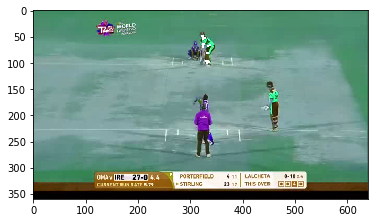

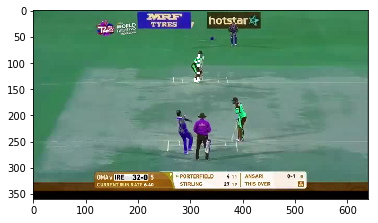

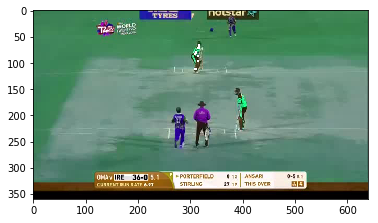

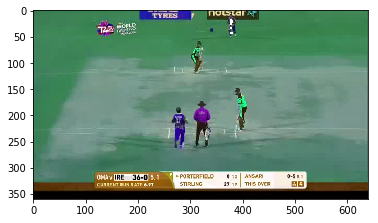

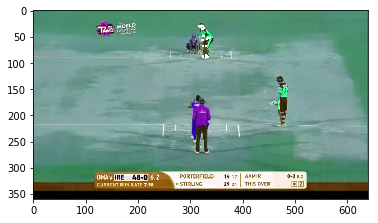

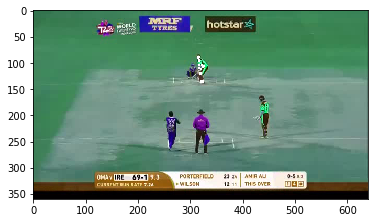

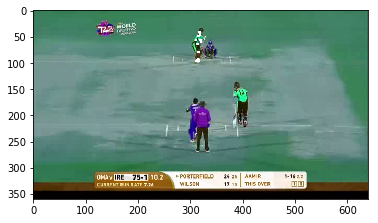

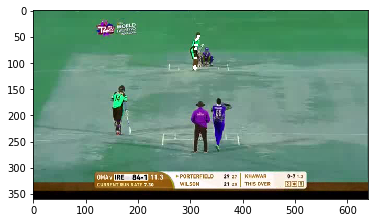

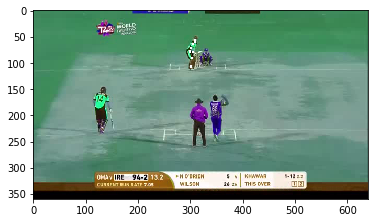

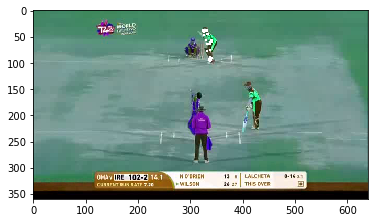

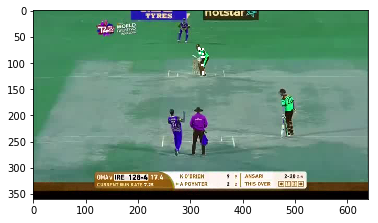

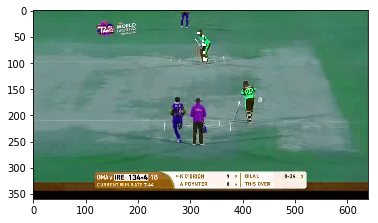

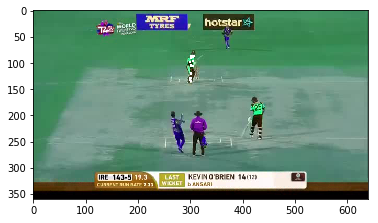

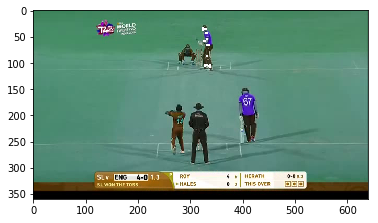

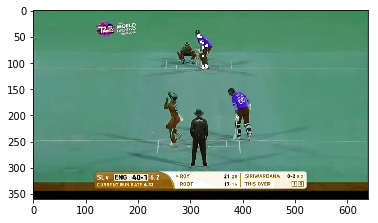

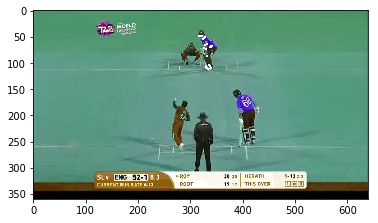

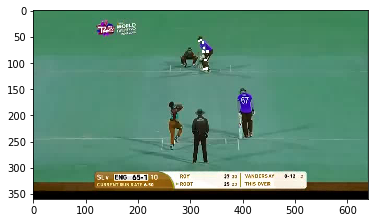

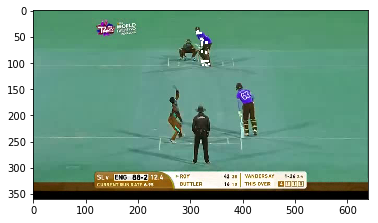

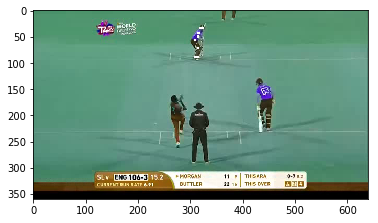

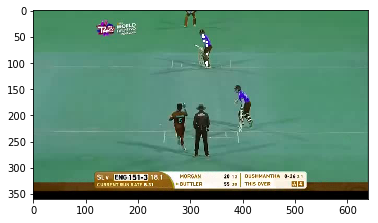

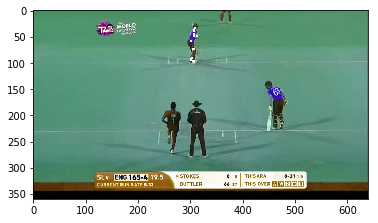

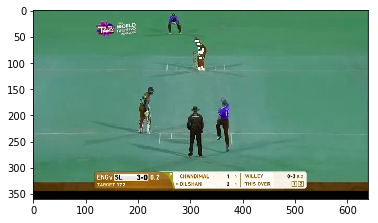

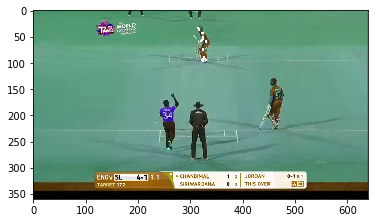

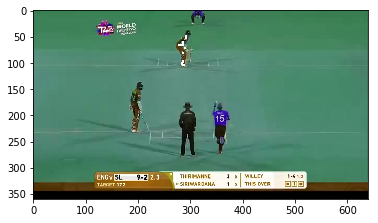

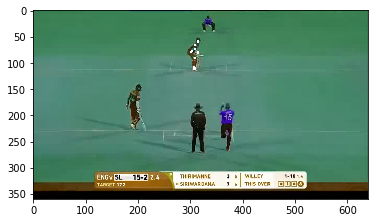

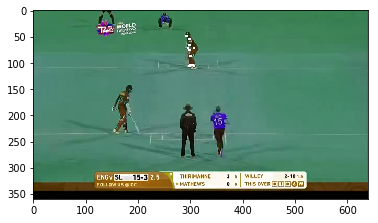

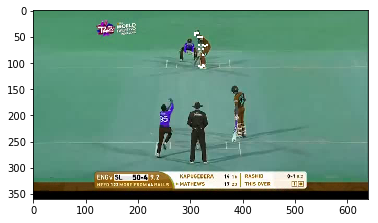

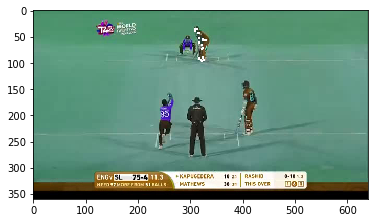

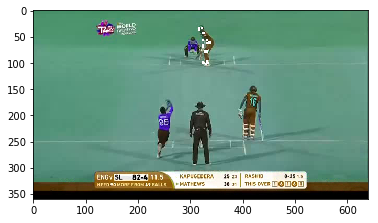

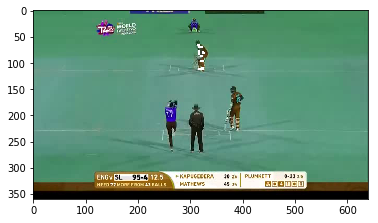

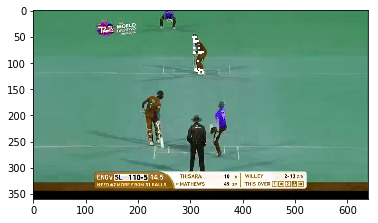

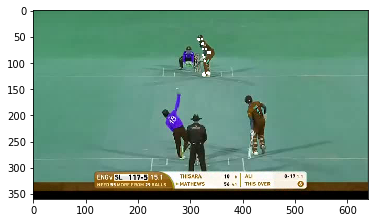

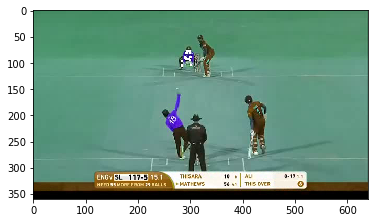

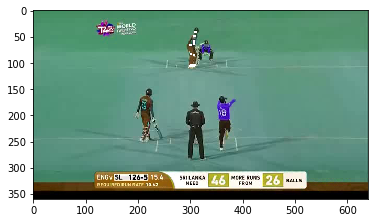

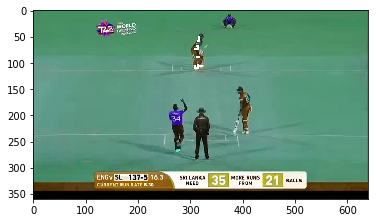

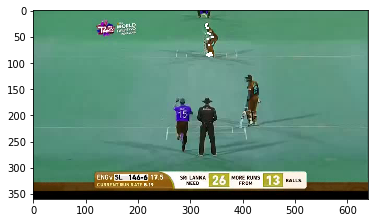

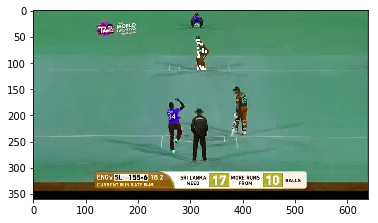

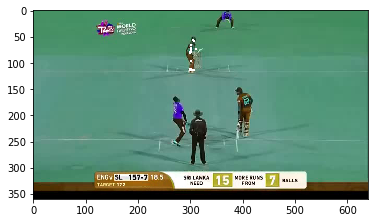

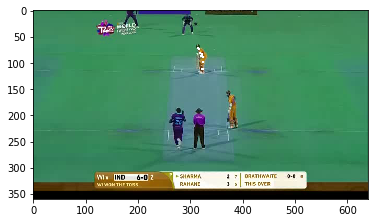

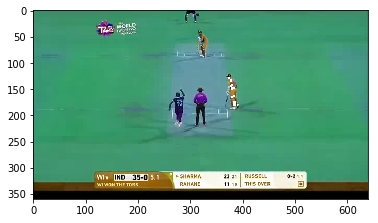

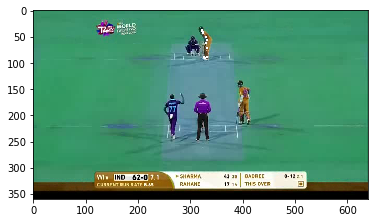

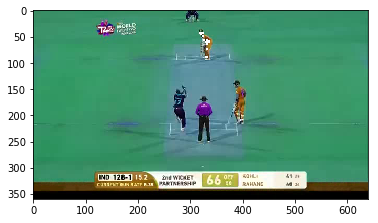

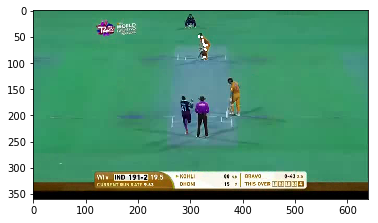

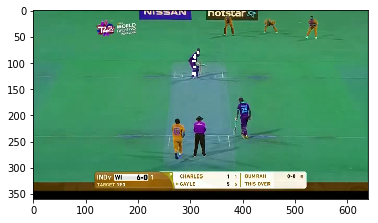

In [44]:
visualizeClusterFrames(all_feats, vnames, f_nos, labels, cluster_no=1)

In [24]:
all_feats

array([[0.569, 0.230, 0.568, 0.238, 0.557, 0.240, 0.546, 0.268, 0.548,
        0.292, 0.580, 0.241, 0.583, 0.262, 0.583, 0.281, 0.568, 0.284,
        0.560, 0.284, 0.554, 0.262, 0.557, 0.300, 0.572, 0.281, 0.591,
        0.268, 0.591, 0.303, 0.568, 0.227, 0.569, 0.227, 0.566, 0.227,
        0.575, 0.227, 0.594, 0.314, 0.594, 0.311, 0.585, 0.311, 0.560,
        0.308, 0.557, 0.311, 0.557, 0.308],
       [0.716, 0.485, 0.742, 0.501, 0.751, 0.491, 0.762, 0.539, 0.000,
        0.000, 0.734, 0.510, 0.742, 0.556, 0.741, 0.602, 0.754, 0.594,
        0.763, 0.586, 0.760, 0.664, 0.767, 0.730, 0.751, 0.594, 0.751,
        0.664, 0.753, 0.738, 0.000, 0.000, 0.718, 0.474, 0.000, 0.000,
        0.727, 0.472, 0.750, 0.751, 0.000, 0.000, 0.759, 0.749, 0.763,
        0.749, 0.768, 0.746, 0.771, 0.743],
       [0.000, 0.000, 0.528, 0.653, 0.545, 0.653, 0.556, 0.708, 0.543,
        0.743, 0.508, 0.651, 0.496, 0.708, 0.508, 0.749, 0.525, 0.765,
        0.539, 0.765, 0.543, 0.849, 0.543, 0.914, 0.513, 0.7

In [32]:
db = dbscan(all_feats, 5, epsilon=0.5)
labs = db.labels_


In [33]:
len(np.where(labs)[0])

2117

In [34]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [35]:
m = np.zeros(all_feats[1].shape)

In [36]:
#m[all_feats[0]>1] = 1
all_feats[1]

array([0.716, 0.485, 0.742, 0.501, 0.751, 0.491, 0.762, 0.539, 0.000,
       0.000, 0.734, 0.510, 0.742, 0.556, 0.741, 0.602, 0.754, 0.594,
       0.763, 0.586, 0.760, 0.664, 0.767, 0.730, 0.751, 0.594, 0.751,
       0.664, 0.753, 0.738, 0.000, 0.000, 0.718, 0.474, 0.000, 0.000,
       0.727, 0.472, 0.750, 0.751, 0.000, 0.000, 0.759, 0.749, 0.763,
       0.749, 0.768, 0.746, 0.771, 0.743])

In [37]:
all_feats.shape

(2498, 50)

In [38]:
cls_data = all_feats[labs==-1]
cls_data.shape

(629, 50)

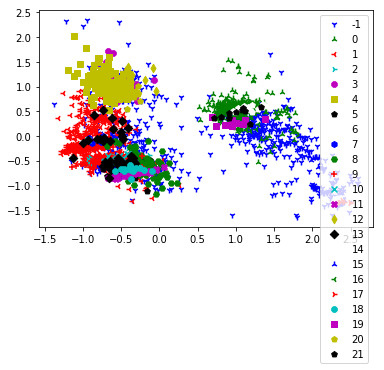

In [41]:
#km = kmeans(all_feats, 5)
#labels = km.labels_
pca_flows = apply_PCA(all_feats)
#pca_flows = apply_tsne(all_feats)
# print("pca_flows", np.shape(pca_flows))
plot_density_clusters(pca_flows, labs)

In [ ]:
km.inertia_

In [ ]:
all_feats[1,:]

In [ ]:
def get_cluster_shots(all_feats, labels):
    
    return